In [21]:
import pandas as pd

# Common Windows encoding
df = pd.read_csv("dataset.csv", encoding="cp1252")

# first need to subset
counties = ["Los Angeles", "San Diego", "Orange", "Riverside", "San Bernardino"]

subset_df = df[df["County"].isin(counties)]

# get rid of the 30-day (done)
# remove location column (done)
# print unique types in hospital rating and see how many unique types, convert to like three of four (there is already three so this looks good)
# do something with the e's 
# Cleaning the Data

subset_df.loc[:, 'Measure'] = subset_df['Measure'].str.replace('30-day ', '')

subset_df.loc[:, '# of Cases'] = pd.to_numeric(subset_df['# of Cases'], errors='coerce')
subset_df.loc[:, '# of Deaths/Readmissions'] = pd.to_numeric(subset_df['# of Deaths/Readmissions'], errors='coerce')


In [22]:
import numpy as np 

subset_df.head()

,Year,County,Hospital,OSHPDID,Measure,Risk Adjusted Rate,# of Deaths/Readmissions,# of Cases,Hospital Ratings,Location 1
92,2011-2012,Los Angeles,Alhambra Hospital,106190017,Readmission,10.40,12.0,96.0,As Expected,"(34.08988, -118.1449)"
93,2011-2012,Los Angeles,Alhambra Hospital,106190017,Mortality,4.63,5.0,100.0,As Expected,"(34.08988, -118.1449)"
94,2011-2012,Los Angeles,Antelope Valley Hospital,106190034,Readmission,14.61,61.0,414.0,As Expected,"(34.68928, -118.15767)"
95,2011-2012,Los Angeles,Antelope Valley Hospital,106190034,Mortality,12.32,41.0,431.0,As Expected,"(34.68928, -118.15767)"
96,2011-2012,Los Angeles,Saint Mary Medical Center,106190053,Readmission,11.55,26.0,189.0,As Expected,"(33.7802376, -118.1866412)"


In [23]:
subset_df=subset_df.loc[:, ['Year','County', 'Hospital','OSHPDID','Measure','Risk Adjusted Rate','# of Deaths/Readmissions','# of Cases','Hospital Ratings']]

In [24]:
subset_df['Hospital Ratings'].unique()

array(['As Expected', 'Worse', 'Better', nan], dtype=object)

In [25]:
subset_df['Measure'].unique()

array(['Readmission', 'Mortality'], dtype=object)

In [26]:
subset_df['Start'] = subset_df['Year'].str.split('-').str[0]
subset_df['Year']=subset_df['Start']
subset_df = subset_df.drop('Start',axis=1)

subset_df['Year'] = pd.to_numeric(subset_df['Year'], errors='coerce')
subset_df.head()

,Year,County,Hospital,OSHPDID,Measure,Risk Adjusted Rate,# of Deaths/Readmissions,# of Cases,Hospital Ratings
92,2011,Los Angeles,Alhambra Hospital,106190017,Readmission,10.40,12.0,96.0,As Expected
93,2011,Los Angeles,Alhambra Hospital,106190017,Mortality,4.63,5.0,100.0,As Expected
94,2011,Los Angeles,Antelope Valley Hospital,106190034,Readmission,14.61,61.0,414.0,As Expected
95,2011,Los Angeles,Antelope Valley Hospital,106190034,Mortality,12.32,41.0,431.0,As Expected
96,2011,Los Angeles,Saint Mary Medical Center,106190053,Readmission,11.55,26.0,189.0,As Expected


In [27]:
# Splitting the data: Rachel

def maxmin(z):
    return (z - np.min(z)) / (np.max(z) - np.min(z))

# Create target and features
y = subset_df['Hospital Ratings']
X = subset_df.loc[:, ['Risk Adjusted Rate', '# of Deaths/Readmissions', "# of Cases", "Year", "County", "Hospital", "Measure"]]

# Select only numeric columns for normalization
X_numeric = X.select_dtypes(include=[np.number])

# Normalize numeric columns
X_normalized = X_numeric.apply(maxmin)

# Recombine normalized numeric + categorical columns
X_final = pd.concat([X_normalized, X.select_dtypes(exclude=[np.number])], axis=1)

# Split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_final, y,
    test_size=0.2,
    random_state=65
)

# had to refine my code in AI as my maxmin function was not working

In [28]:
# one hot encode: Helen
#X = subset_df

ddf = pd.get_dummies(X['County'],dtype='int')
X['County'] = X['County'].fillna('Unknown')

from sklearn.preprocessing import LabelBinarizer

one_hot_encoder = LabelBinarizer()
oh = one_hot_encoder.fit_transform(X['County']) # One-hot encode the 'bird' variable
#print(oh)
names = one_hot_encoder.classes_ # Get names of the classes
#print(names)

zdf = pd.DataFrame( data = oh, columns = names) # Create a new df for the encoded variables
zdf.head()

,Los Angeles,Orange,Riverside,San Bernardino,San Diego
0,1,0,0,0,0
1,1,0,0,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,1,0,0,0,0


In [29]:
# One hot encode: helen
Ddf = pd.get_dummies(X['Measure'], dtype=int)
X['Measure'] = X['Measure'].fillna('Unknown')

X['Measure'] = X['Measure'].fillna('Unknown')
ldf = pd.get_dummies(X['Measure'], dtype=int)

X['Hospital'] = X['Hospital'].fillna('Unknown')
hospital_dummies = pd.get_dummies(X['Hospital'], prefix='Hospital', dtype=int)

ldf.head()

,Mortality,Readmission
92,0,1
93,1,0
94,0,1
95,1,0
96,0,1


In [30]:
# accuracy, Rachel

X = X.drop(['County', 'Measure','Hospital'], axis=1, errors='ignore')
X = pd.concat([X, ddf, Ddf, hospital_dummies], axis=1)

from sklearn.preprocessing import LabelEncoder

# Encode the target variable y # this is from AI because I had all of this code and it was not working
le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42
)

from sklearn import tree # Import the tree classifier
cart = tree.DecisionTreeClassifier() # Create a classifier object
cart = cart.fit(X_train, y_train) # Fit the classifier

## Make Predictions on the Test Set:
y_hat = cart.predict(X_test)

## Confusion Matrix:
tab = pd.crosstab(y_test,y_hat) # Compute confusion matrix
acc = (tab.iloc[0,0]+tab.iloc[1,1])/len(y_test) # Compute Accuracy
#acc = np.trace(tab)/len(y_test)  # Faster way to compute accuracy
print('Accuracy: ', acc, '\n')
pd.crosstab(y_test,y_hat)

Accuracy:  0.9223300970873787 



col_0,0,1,2
row_0,,,
0,186,3,2
1,4,4,0
2,2,0,4
3,1,0,0


In [35]:
# Split data into training rows and testing rows:
N = subset_df.shape[0]
df = subset_df.sample(frac=1, random_state=100) # randomize the order in which data appears
train_size = int(.8*N)
df_train = subset_df[0:train_size]
N_train = df_train.shape[0]
df_test = subset_df[train_size:]

# Remove rows with missing target
df_train = df_train.dropna(subset=['Risk Adjusted Rate'])
df_test = df_test.dropna(subset=['Risk Adjusted Rate'])

N_test = df_test.shape[0]

df_train.head()

,Year,County,Hospital,OSHPDID,Measure,Risk Adjusted Rate,# of Deaths/Readmissions,# of Cases,Hospital Ratings
92,2011,Los Angeles,Alhambra Hospital,106190017,Readmission,10.40,12.0,96.0,As Expected
93,2011,Los Angeles,Alhambra Hospital,106190017,Mortality,4.63,5.0,100.0,As Expected
94,2011,Los Angeles,Antelope Valley Hospital,106190034,Readmission,14.61,61.0,414.0,As Expected
95,2011,Los Angeles,Antelope Valley Hospital,106190034,Mortality,12.32,41.0,431.0,As Expected
96,2011,Los Angeles,Saint Mary Medical Center,106190053,Readmission,11.55,26.0,189.0,As Expected


In [36]:
T = 1000
m_depth = 10
Rsq = np.zeros(T) # preallocate the rsq measure
y_test_hat = np.zeros([T,N_test]) # preallocate predictions on test set

# Split data into train/test:
X_train = df_train.drop(['Risk Adjusted Rate'],axis=1)
y_train = np.arcsinh(df_train['Risk Adjusted Rate'])
X_test = df_test.drop(['Risk Adjusted Rate'],axis=1)
y_test = np.arcsinh(df_test['Risk Adjusted Rate'])

cat_cols = ['County', 'Hospital', 'Measure', 'Hospital Ratings']  # update with your string columns
X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Bootstrapping:
for s in range(T):
    # Generate a bootstrap sample:
    df_s = df_train.sample(frac=1, replace=True)
    X_s = df_s.drop('Risk Adjusted Rate',axis=1)
    X_s = pd.get_dummies(X_s, columns=cat_cols, drop_first=True)
    X_s = X_s.reindex(columns=X_train.columns, fill_value=0)
    y_s = np.arcsinh(df_s['Risk Adjusted Rate'])
    # Fit decision tree:
    cart = tree.DecisionTreeRegressor(max_depth=m_depth) # Create a classifier object
    cart = cart.fit(X_s, y_s) # Fit the classifier
    # Compute Rsq:
    y_hat = cart.predict(X_test)
    SSE = np.sum( (y_test-y_hat)**2 )
    TSS = np.sum( (y_test-y_s.mean())**2 )
    Rsq[s] = 1 - SSE/TSS
    # Make and Save Predictions:
    y_test_hat[s,:] = y_hat

# Ensemble predictor:
y_hat_ensemble = y_test_hat.mean(axis=0) # Average the columns to get the ensemble prediction
SSE = np.sum( (y_test-y_hat_ensemble)**2 )
TSS = np.sum( (y_test-y_train.mean())**2 )
Rsq_ensemble = 1 - SSE/TSS

print(Rsq_ensemble)

0.7553007424385453


In [40]:
# One-step multilinear regression:
subset_df = subset_df.dropna(subset=['# of Deaths/Readmissions','# of Cases','Risk Adjusted Rate'])

def mlr(X,y): # Multiple linear regression, matrix algebra approach
    XpX = X.T@X # Compute X'X
    Xpy = X.T@y # Compute X'y
    b = np.linalg.solve(XpX, Xpy) # Solve normal equations
    y_hat = X@b # Compute predictions
    residuals = y-y_hat # Compute residuals
    SSE =  np.inner(residuals,residuals) # Compute SSE
    rsq = 1 - SSE/np.inner( y-np.mean(y),y-np.mean(y)) # Compute Rsq
    return({'b':b,'y_hat':y_hat,'residuals':residuals,'rsq':rsq,'SSE':SSE})

subset_df['(Intercept)'] = 1
X = subset_df.loc[:,['(Intercept)','# of Deaths/Readmissions','# of Cases'] ]
y = subset_df['Risk Adjusted Rate']
reg = mlr(X,y)
print('MLR coefficients: ', reg['b']) # Same values!

MLR coefficients:  [1.09411585e+01 5.78389448e-04 1.47452400e-03]


C:\Users\rache\AppData\Local\Temp\ipykernel_30036\815696381.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['(Intercept)'] = 1


[1.09411585e+01 5.78389448e-04 1.47452400e-03]
0.005679625921407916


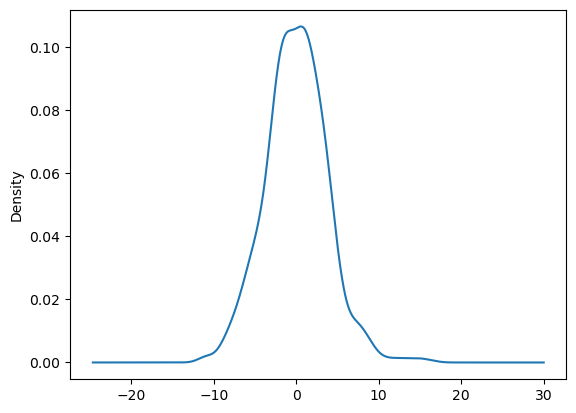

In [42]:
reg = mlr(X,y) # Run multiple linear regression
print(reg['b']) # Print coefficients 
reg['residuals'].plot.kde() # Plot residuals
print(reg['rsq']) 